<a href="https://colab.research.google.com/github/hwizard-wph/NAS/blob/main/Evolution_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

from nasbench import api

nasbench = api.NASBench('nasbench_only108.tfrecord')

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0   191M      0  0:00:02  0:00:02 --:--:--  191M
Cloning into 'nasbench'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 96 (delta 29), reused 22 (delta 22), pack-reused 51
Unpacking objects: 100% (96/96), done.
Processing ./nasbench
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nasbench: filename=nasbench-1.0-py

In [ ]:
import copy
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2
OP_SPOTS = NUM_VERTICES - 2 
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1] 

In [ ]:
def random_spec():
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec


In [ ]:
def mutate_spec(old_spec):
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    edge_threshold = 1.0 / NUM_VERTICES
    for i in range(0, NUM_VERTICES - 1) :
      for j in range(i + 1, NUM_VERTICES) : 
        if random.random() < edge_threshold:
          new_matrix[i, j] = 1 - new_matrix[i, j]
          
    op_threshold = 1.0 / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_threshold:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
    new_spec = api.ModelSpec(new_matrix, new_ops)

    if nasbench.is_valid(new_spec):
      return new_spec

In [ ]:
def run_evolution_search(cycles, population_size, tournament_size):
  nasbench.reset_budget_counters()
  population = []
  history = []
  best_vali = 0.0
  best_test = 0.0
  for _ in range(min(cycles, population_size)):
    spec = random_spec()
    data = nasbench.query(spec)
    population.append((data['validation_accuracy'], spec))
    history.append((data['validation_accuracy'], spec))
    if data['validation_accuracy'] > best_vali:
      best_vali = data['validation_accuracy']
      best_test = data['test_accuracy']
  while len(history) < cycles:
    sample = []
    while len(sample) < tournament_size:
      candidate = random.choice(population)
      sample.append(candidate)
    parent = max(sample, key = lambda i:i[0])
    child_spec = mutate_spec(parent[1])
    child_data = nasbench.query(child_spec)
    child = (child_data['validation_accuracy'], child_spec)
    if child_data['validation_accuracy'] > best_vali:
      best_vali = child_data['validation_accuracy']
      best_test = child_data['test_accuracy']
    population.append(child)
    history.append(child)
    population.pop(0)
  
  return best_test

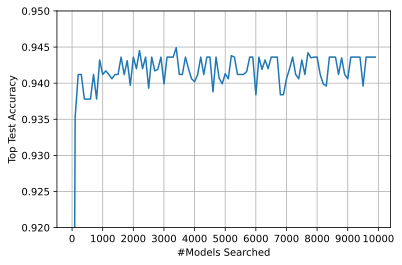

In [ ]:
xval = []
yval = []
for _ in range(1, 10001, 100):
  xval.append(_)
  yval.append(run_evolution_search(_, 100, 50))
plt.plot(xval, yval)
plt.ylim(0.92, 0.95)
plt.grid()
plt.ylabel('Top Test Accuracy')
plt.xlabel('#Models Searched')
x_major_locator = MultipleLocator(1000)
y_major_locator = MultipleLocator(0.005)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)